# IHLS demo on a single pair of images

This notebook shows how to use the IHLS solver with LoFTR matcher for the relative camera pose estimation task.

In [ ]:
import os
from copy import deepcopy

from kornia.geometry.epipolar import essential_from_fundamental, motion_from_essential_choose_solution
import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from src.utils.plotting import make_matching_figure
from src.fm.utils.irls import FundamentalMatrixEstimator
from src.utils.metrics import relative_pose_error

## Indoor Example

In [2]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
_default_cfg = deepcopy(default_cfg)
_default_cfg['coarse']['temp_bug_fix'] = True  # set to False when using the old ckpt
matcher = LoFTR(config=_default_cfg)
matcher.load_state_dict(torch.load("weights/indoor_irls_e2e.ckpt")['state_dict'], strict=False)
matcher = matcher.eval().cuda()
ihls = FundamentalMatrixEstimator(p=0.5)

### 1) Run matcher

In [ ]:
# Load example images
img0_pth = "assets/scannet_sample_images/scene0711_00_frame-001680.jpg"
img1_pth = "assets/scannet_sample_images/scene0711_00_frame-001995.jpg"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'][None]
    mkpts1 = batch['mkpts1_f'][None]
    mconf = batch['mconf'][None]

### 2) Estimate Relative Pose

In [4]:
# load gt pose
meta_info = np.load('assets/scannet_test_1500/test.npz')
pair_mask = (meta_info['name'] == np.array([711, 0, 1680, 1995])).all(-1)
rel_pose = meta_info['rel_pose'][pair_mask].reshape(3, 4)
# load gt intrinsics
intrinsics = np.load('assets/scannet_test_1500/intrinsics.npz')['scene0711_00']
intrinsics = torch.from_numpy(intrinsics)[None].float().to(mkpts0.device)
# estimate fundamental matrix with IHLS
F, stats, weights = ihls(mkpts0, mkpts1, mconf)
F = F[:, 0]
# compute pose error
E = essential_from_fundamental(F, intrinsics, intrinsics)
R, t, _ = motion_from_essential_choose_solution(E, intrinsics, intrinsics, mkpts0, mkpts1)
R = R[0].cpu().numpy()
t = t[0,..., 0].cpu().numpy()
t_err, R_err = relative_pose_error(rel_pose, R, t, ignore_gt_t_thr=0.0)

In [5]:
mkpts0 = mkpts0[0].cpu().numpy()
mkpts1 = mkpts1[0].cpu().numpy()
mconf = mconf[0].cpu().numpy()

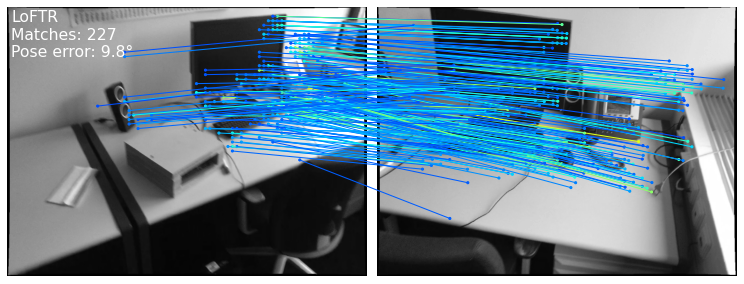

In [6]:
# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
    'Pose error: {:.1f}°'.format(max(t_err, R_err))
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)